# Background

A popular alternative to this approach is independent component analysis (ICA). In a nutshell, ICA decomposes multi-channel EEG recordings into maximally independent components. Components that represent ocular activity can be identified and eliminated to reconstruct artifact-free EEG signals. This approach is described in more detail in Jung et al. (2000).

A comprehensive comparison between the two methods is beyond the scope of this post. Instead, I will only list some important properties of both techniques.

First, the regression-based approach requires EOG channels, whereas ICA works without any reference signal.

Both methods potentially remove brain activity in addition to ocular activity. ICA can separate ocular components from brain components well if many EEG channels are available (which in turn requires a relatively large number of data samples). A cleaner separation also means that less brain activity will be removed when ocular components are eliminated. The minimum number of EEG channels required for ICA decomposition varies, but as a rule of thumb at least 20 channels seem to be necessary (the EEGLAB tutorial has more details on the amount of data required for ICA). In constrast, the regression approach works even if only a few EEG channels are available. However, the EOG reference channels always contain some amount of brain activity, which will also be removed from the data in addition to ocular activity.

The ICA method entails manual identification of ocular components, although several algorithms exist to automate this process (for example EyeCatch or ADJUST). ICA also takes longer to compute than the regression approach (but efficient implementations are available that keep computation time to a minimum). Finally, ICA is an optimization problem that is not guaranteed to find the globally optimal solution. Depending on the initial conditions, the algorithm might find different independent components from run to run. However, this is not a huge issue in this application, because ocular components are relatively stable across decompositions.

Let’s now turn to an example to see how ICA can be used to remove ocular artifacts with MNE.

# Implementation

Before we start, it is worth mentioning that ICA will generally run faster using a multi-threaded numeric library such as Intel MKL or OpenBLAS. If you have an Anaconda environment (which I recommend in this previous post), you should already have NumPy with MKL support.

# Data preprocessing

We will use the same data set that we already used with the regression approach. Specifically, we’ll use participant A01T from data set 001-2014 from the BNCI Horizon 2020 website. Download this file and save it to your working directory. Note that this data set contains 22 EEG and 3 EOG channels. Although EOG channels can (and should) be used for ICA decomposition (provided that they use the same reference electrode as the EEG channels), we will only use EEG channels here to keep things simple.

As always, we start by firing up IPython and performing the usual initial steps:

In [1]:
from scipy.io import loadmat
import mne


The data comes in a MAT file, so we use SciPy’s loadmat function to load it as a NumPy array. Note that this time we only load the fourth run containing the actual experimental data – we do not need the calibration run.

In [2]:
mat = loadmat("A01T.mat", simplify_cells=True)
eeg = mat["data"][3]["X"] * 1e-6  # convert to volts


In [3]:
mat = loadmat("A01T.mat", simplify_cells=True)
eeg = mat["data"][3]["X"] * 1e-6  # convert to volts

We will plot ICA components as projections on the scalp surface later on. To this end, MNE needs to know the channel labels, which unfortunately are not present in the data. However, the data description contains a picture of the montage, which we can use to populate a list of channel names.

In [4]:
ch_names = ["Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz",
            "C2", "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz",
            "P2", "POz", "EOG1", "EOG2", "EOG3"]

We create an info object using this list, which we need to create a Raw object containing the EEG data and associated meta information (which in our case is just the sampling frequency of 250 Hz and the channel types). Finally, we add a standard 10–20 montage, which maps the channel labels to their locations on the scalp. This is required for topographic plots.

In [5]:
info = mne.create_info(ch_names, 250, ch_types=["eeg"] * 22 + ["eog"] * 3)
raw = mne.io.RawArray(eeg.T, info)
raw.set_montage("standard_1020")


Creating RawArray with float64 data, n_channels=25, n_times=96735
    Range : 0 ... 96734 =      0.000 ...   386.936 secs
Ready.


<RawArray | 25 x 96735 (386.9 s), ~18.5 MB, data loaded>

# Performing ICA


ICA does not work in the presence of low-frequency drifts, so we create a copy of our raw object and apply a high-pass filter to this copy.

In [6]:
raw_tmp = raw.copy()
raw_tmp.filter(l_freq=1, h_freq=None)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



<RawArray | 25 x 96735 (386.9 s), ~18.5 MB, data loaded>

We are now ready to perform ICA. First, we instantiate an ICA object and specify that we want to use the extended Infomax algorithm. Note that you can (and should) use the picard method from the python-picard package – this algorithm computes the extended Infomax solution much faster (see here for more details). In any case, the random_state argument should be set for reproducible results.

In [7]:
ica = mne.preprocessing.ICA(method="infomax",
                            fit_params={"extended": True},
                            random_state=1)


Next, we fit ica to our filtered raw data raw_tmp (note that this uses only the 22 EEG channels and ignores the 3 EOG channels by default, but this can be changed with the picks argument).

In [8]:
ica.fit(raw_tmp)

Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 25.2s.


<ICA | raw data decomposition, method: infomax (fit in 500 iterations on 96735 samples), 22 ICA components explaining 100.0 % of variance (22 PCA components available), channel types: eeg, no sources marked for exclusion>

# Identifying ocular components

Our next task is to identify ocular components. This is usually done by visual inspection, so we start by plotting all 22 independent components.

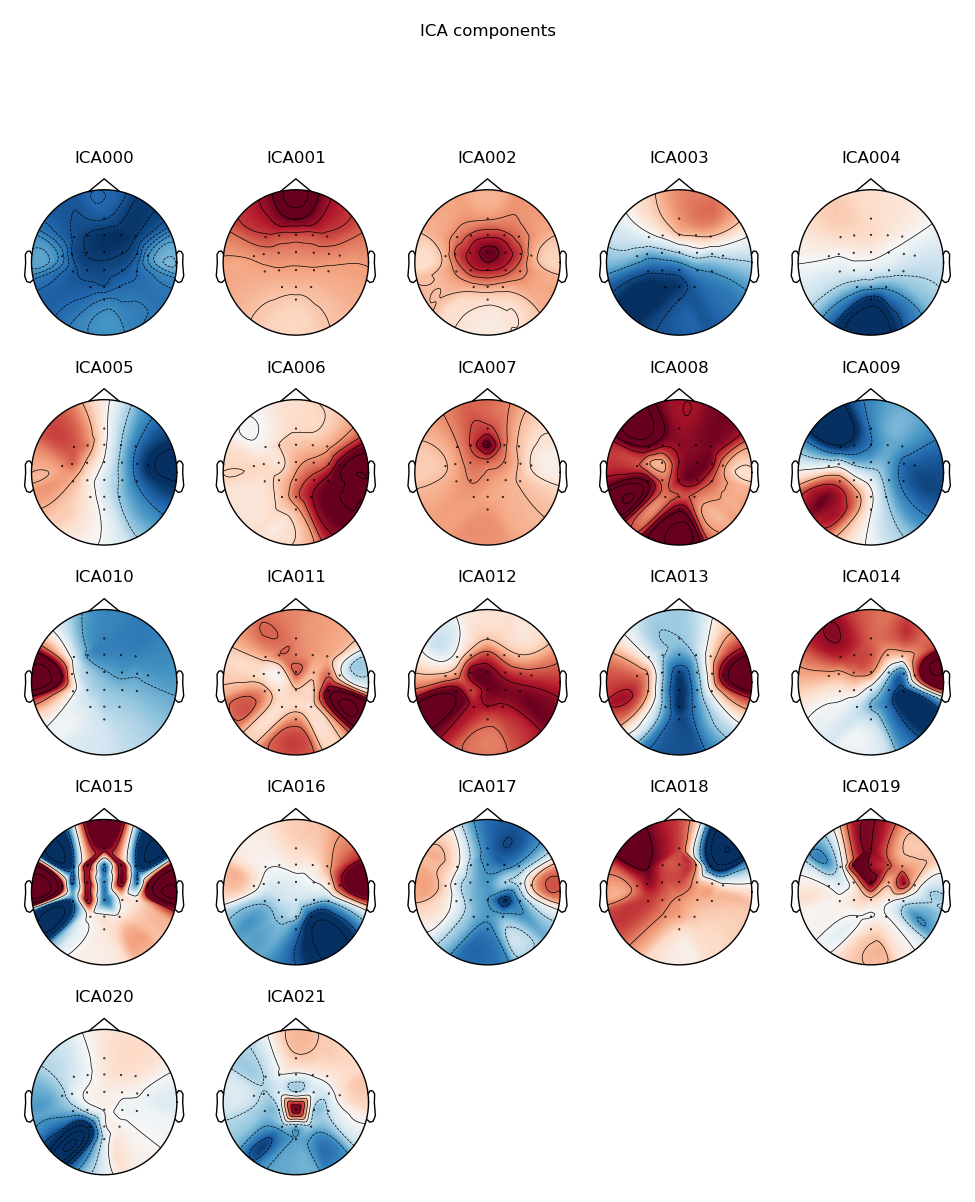

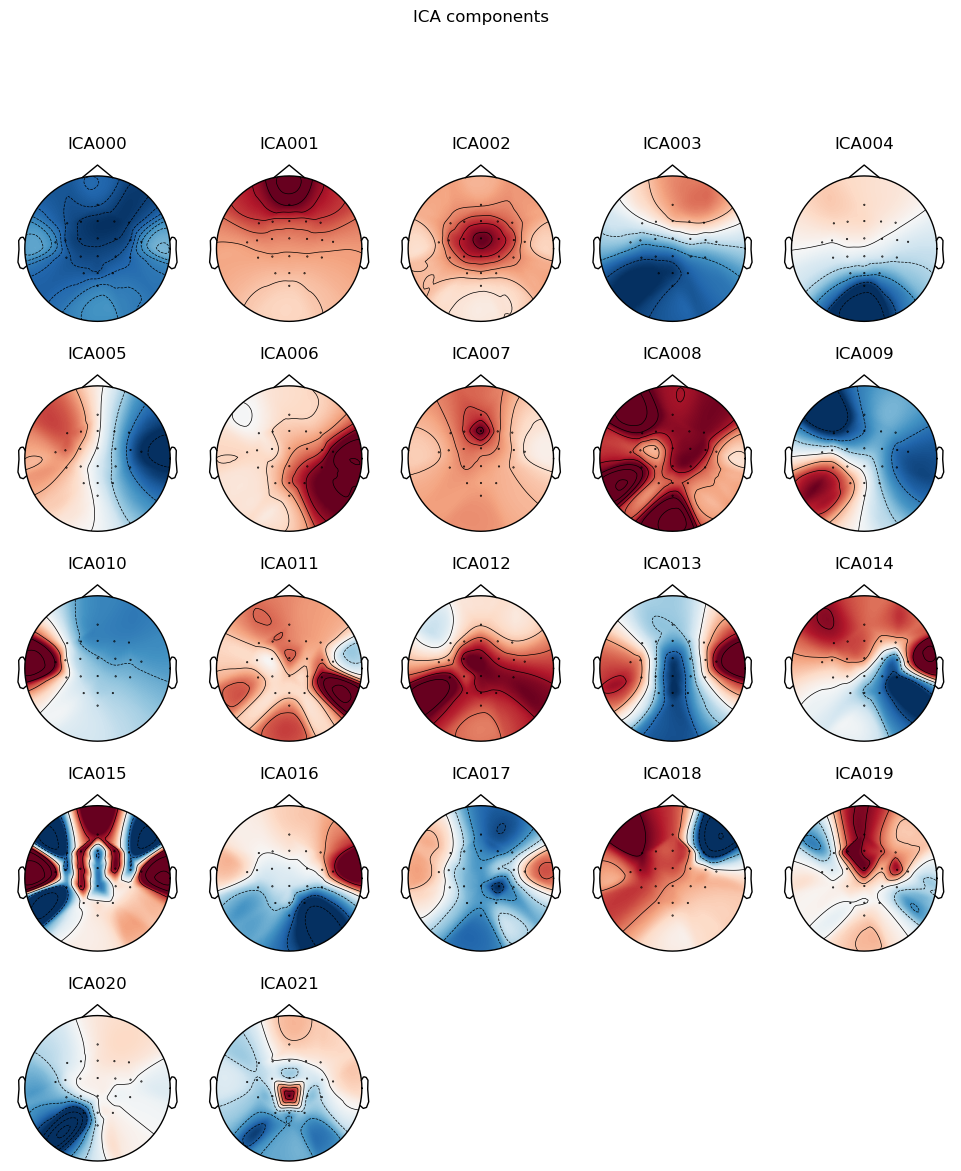

In [9]:
%matplotlib widget
ica.plot_components(inst=raw_tmp, picks=range(22))

From these scalp projections, the component labeled as **ICA001** looks like it could represent eye movements because of its frontal location. (this is possible because we specified inst=raw_tmp in the previous call)


Creating RawArray with float64 data, n_channels=25, n_times=96735
    Range : 0 ... 96734 =      0.000 ...   386.936 secs
Ready.
Using matplotlib as 2D backend.


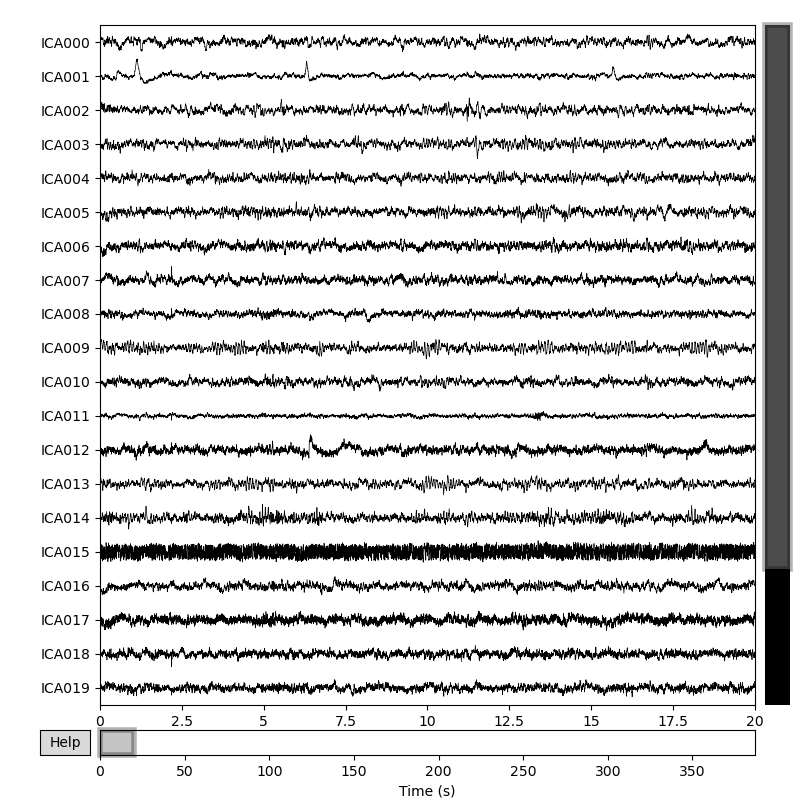

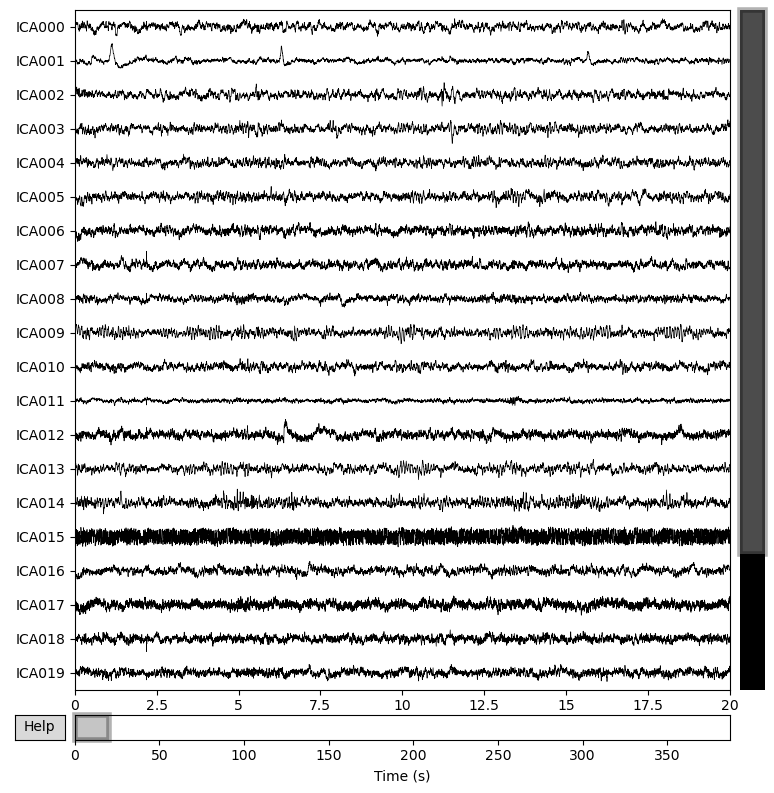

In [10]:
ica.plot_sources(inst=raw_tmp)

Indeed, if you scroll through the data, ICA001 captures primarily eye movements and eye blinks.

Note that usually two ocular components can be found in the decomposition, but this is not the case in our example data (all remaining components do not seem to originate from eye activity).

# Removing ocular components


In the final step, we create a list attribute ica.exclude containing the indices of all components that should be removed when reconstructing EEG signals. In our case, this list contains only a single component.

In [11]:
ica.exclude = [1]

Note that you can click on the component title (ICA001) in the ICA components plot created with ica.plot_components(inst=raw_tmp, picks=range(22)) to include/exclude a component (the title of an excluded component will turn gray). This will also add/remove this component from/to the underlying ica.exclude list.

Now we can apply our ICA results (without the excluded component) to a copy of the original (unfiltered) EEG to obtain artifact-free signals:

In [13]:
raw_corrected = raw.copy()
ica.apply(raw_corrected)

Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


<RawArray | 25 x 96735 (386.9 s), ~18.5 MB, data loaded>

# Visualizing results

So how did ICA perform? Let’s take a look at a segment of the original EEG containing a clear eye movment artifact:

**Before**

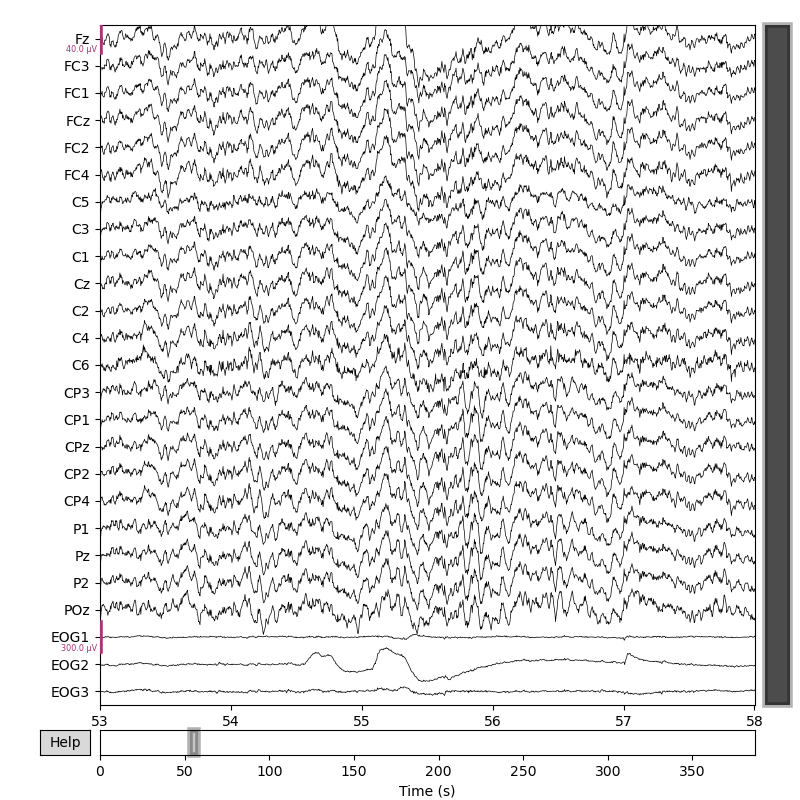

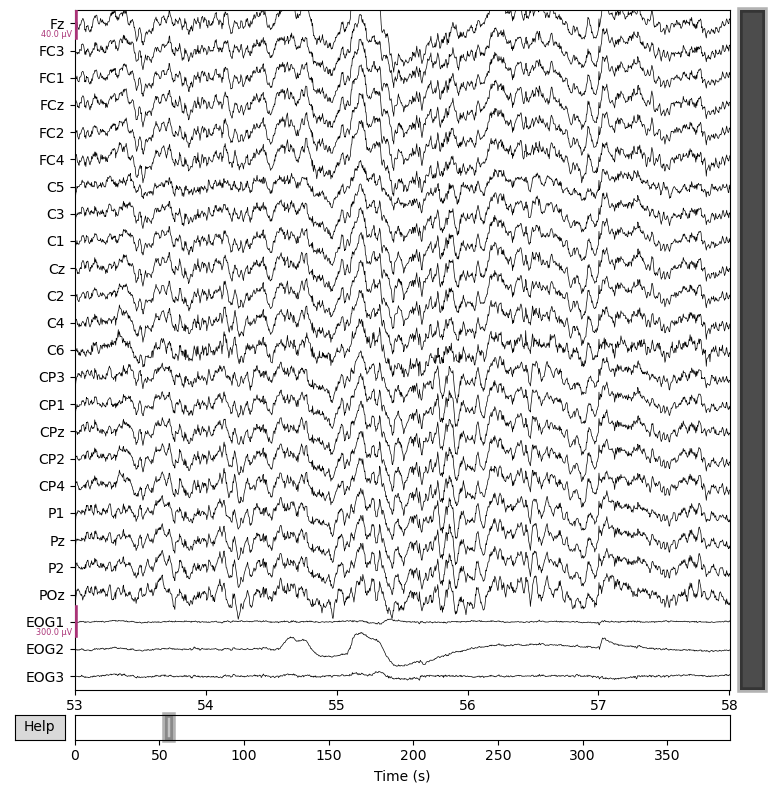

In [15]:
raw.plot(n_channels=25, start=53, duration=5, title="Before")

And here is the corrected signal:

**After**

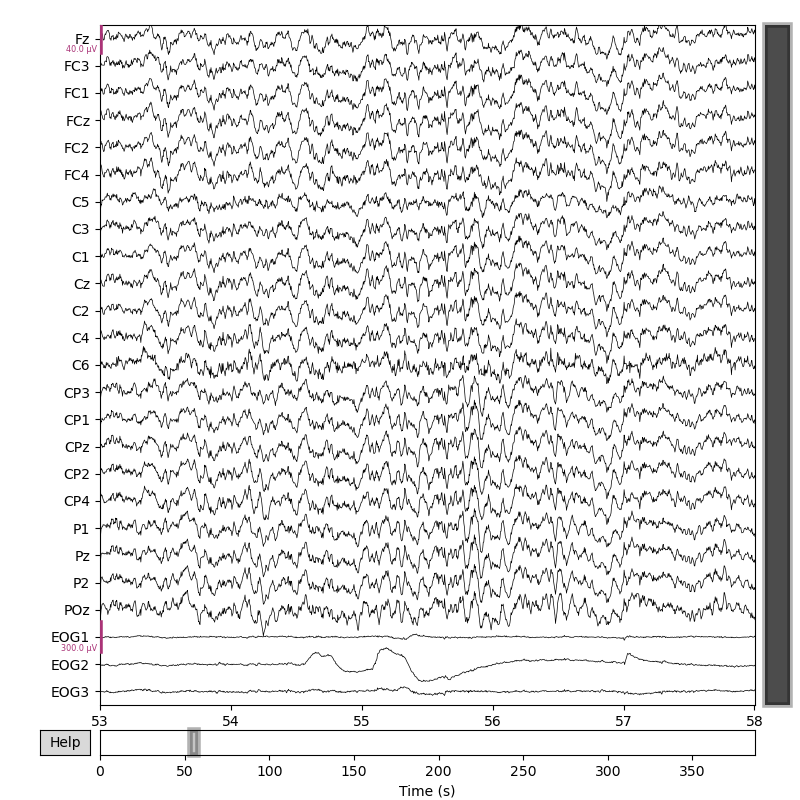

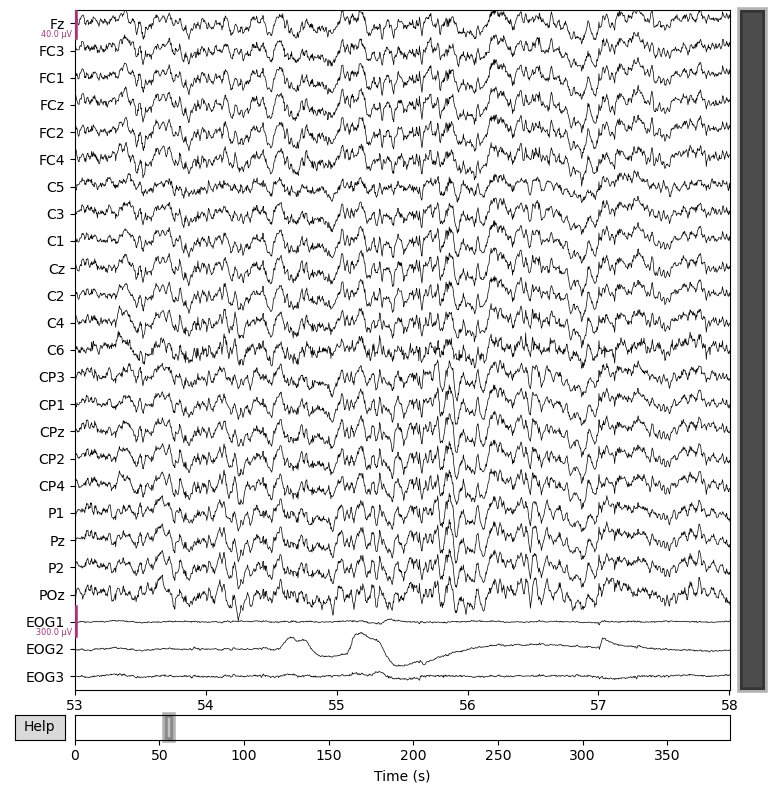

In [16]:
raw_corrected.plot(n_channels=25, start=53, duration=5, title="After")


# Looks like ICA did a pretty decent job in removing eye artifacts.

